In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install mne

Note: you may need to restart the kernel to use updated packages.


In [3]:
import mne
from glob import glob
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


creating a list with the paths of the adhd files

In [4]:

ADHD_files_path=glob('/kaggle/input/adhd-classification-data/ADHD_fif-20240509T211140Z-001/ADHD_fif/*.fif')
print(len(ADHD_files_path))

61


creating a list with the paths of the control files

In [5]:
control_files_path=glob('/kaggle/input/adhd-classification-data/Control_fif-20240509T211233Z-001/Control_fif/*.fif')
print(len(control_files_path))

60


creating a function to read the data and create a fixed epochs of duration 10 sec and overlapping of 75%

In [6]:
def read_data(file_path):
    datax=mne.io.read_raw_fif(file_path,preload=True)
    epochs=mne.make_fixed_length_epochs(datax,duration=10,overlap=0.75)
    epochs=epochs.get_data() #turning the epochs to arrays
    return epochs

In [ ]:
#reading the data of both ADHD and control and saving them in an array
NON_ADHD_epochs_array=[read_data(subject) for subject in control_files_path]
ADHD_epochs_array=[read_data(subject) for subject in ADHD_files_path]

In [8]:
#crating target values for each data
NON_ADHD_epochs_labels=[len(i)*[0] for i in NON_ADHD_epochs_array]
ADHD_epochs_labels=[len(i)*[1] for i in ADHD_epochs_array]
print(len(NON_ADHD_epochs_labels),len(ADHD_epochs_labels))

60 61


In [10]:
#adding data of both adhd with control in one array
data_list=NON_ADHD_epochs_array+ADHD_epochs_array
#adding the target values of both adhd and control with eachother
label_list=NON_ADHD_epochs_labels+ADHD_epochs_labels
print(len(data_list),len(label_list))

121 121


In [41]:
#stacking the values beside eachother
data_array=np.vstack(data_list)
label_array=np.hstack(label_list)
data_array=np.moveaxis(data_array,1,2)

print(data_array.shape,label_array.shape,group_array.shape)

(1756, 1280, 19) (1756,) (1756,)


In [17]:
#creating cnn model suitable for the data
from tensorflow.keras.layers import Conv1D, BatchNormalization, LeakyReLU, MaxPool1D, GlobalAveragePooling1D, Dense, Dropout, AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam

def cnnmodel():
    clear_session()
    model = Sequential()
    model.add(Conv1D(filters=8, kernel_size=3, strides=1, input_shape=(1280, 19))) # 1
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2, strides=2)) # 2
    model.add(Conv1D(filters=16, kernel_size=3, strides=1)) # 3
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2, strides=2)) # 4
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=32, kernel_size=3, strides=1)) # 5
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2, strides=2)) # 6
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=64, kernel_size=3, strides=1)) # 7
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2, strides=2)) # 8
    model.add(Conv1D(filters=128, kernel_size=3, strides=1)) # 9
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2, strides=2)) # 10
    model.add(Conv1D(filters=256, kernel_size=3, strides=1)) # 11
    model.add(LeakyReLU())
    model.add(GlobalAveragePooling1D()) # 12
    model.add(Dense(128)) # 13
    model.add(LeakyReLU())
    model.add(Dense(64)) # 14
    model.add(LeakyReLU())
    model.add(Dense(1, activation='sigmoid')) # 15
    opt = Adam(learning_rate=0.0001)
    model.compile(opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = cnnmodel()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1278, 8)        │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1278, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1278, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 639, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 637, 16)        │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 637, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 318, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 318, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 316, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 316, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 158, 32)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 158, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 156, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 156, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 78, 64)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 76, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 76, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_2             │ (None, 38, 128)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 36, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 36, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 173,153 (676.38 KB)

 Trainable params: 173,137 (676.32 KB)

 Non-trainable params: 16 (64.00 B)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split dataset into train, validation, and test sets
train_features, test_val_features, train_labels, test_val_labels = train_test_split(data_array, label_array, test_size=0.2, random_state=42)
val_features, test_features, val_labels, test_labels = train_test_split(test_val_features, test_val_labels, test_size=0.5, random_state=42)

# Standardize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
val_features = scaler.transform(val_features.reshape(-1, val_features.shape[-1])).reshape(val_features.shape)
test_features = scaler.transform(test_features.reshape(-1, test_features.shape[-1])).reshape(test_features.shape)


model = cnnmodel()

# Train the model
model.fit(train_features, train_labels, epochs=75, batch_size=128, validation_data=(val_features, val_labels))



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/75
 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4466 - loss: 0.6941

I0000 00:00:1715968742.601669     154 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4891 - loss: 0.6934  

W0000 00:00:1715968752.649206     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.4927 - loss: 0.6933 - val_accuracy: 0.5398 - val_loss: 0.6937
Epoch 2/75
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5766 - loss: 0.6884 - val_accuracy: 0.5398 - val_loss: 0.6942
Epoch 3/75
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5595 - loss: 0.6890 - val_accuracy: 0.5398 - val_loss: 0.6917
Epoch 4/75
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5654 - loss: 0.6880 - val_accuracy: 0.5398 - val_loss: 0.6901
Epoch 5/75
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5652 - loss: 0.6857 - val_accuracy: 0.5398 - val_loss: 0.6884
Epoch 6/75
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5748 - loss: 0.6812 - val_accuracy: 0.5511 - val_loss: 0.6855
Epoch 7/75
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5718 - loss: 0.6788 - val_accuracy: 0.5682 - val_loss: 0.6803
Epoch 8/75
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6140 - loss: 0.6702 - val_accuracy: 0.5966 - val_loss: 0.6

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


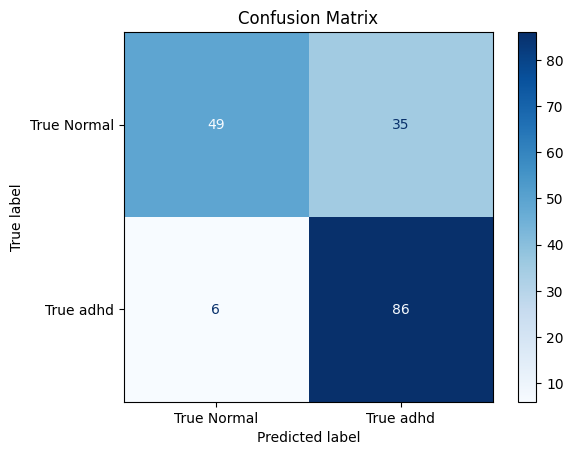

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7833 - loss: 0.4844


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
# Make predictions on test set
predictions = model.predict(test_features)
binary_predictions = np.round(predictions).flatten()

# Calculate confusion matrix
cm = confusion_matrix(test_labels, binary_predictions)

# Plot confusion matrix
labels = ['Normal', 'adhd']  
display_labels = ['True ' + label for label in labels]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy.append(model.evaluate(test_features, test_labels)[1])

In [21]:
from sklearn.metrics import classification_report

# Calculate precision, recall, F1-score, and support
report = classification_report(test_labels, binary_predictions, target_names=['NORMAL', 'ADHD'])

# Print the classification report
print(report)

              precision    recall  f1-score   support

      NORMAL       0.89      0.58      0.71        84
        ADHD       0.71      0.93      0.81        92

    accuracy                           0.77       176
   macro avg       0.80      0.76      0.76       176
weighted avg       0.80      0.77      0.76       176



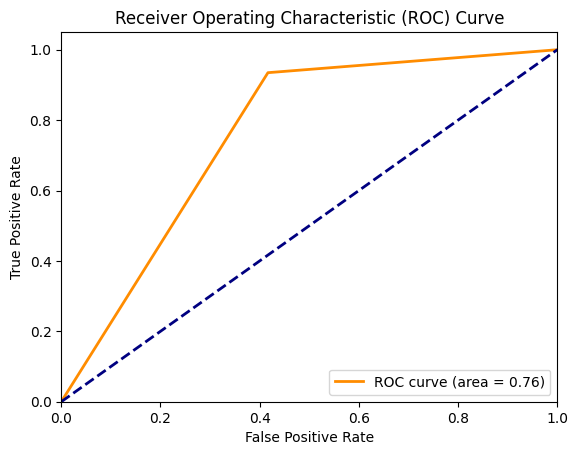

In [22]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_labels, binary_predictions)

# Calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()